In [1]:
import matplotlib.pyplot as plt 
plt.rcParams.update({
    'font.size': 20,
    'figure.figsize': (12, 6)
})
plt.rc('font', family='arial')

In [2]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-labs/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-labs/quinlan/data-shared/constraint-tools'

import sys
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

In [3]:
GC_WINDOW_SIZE = 1000

## Non-exonic non-enhancer Chen windows, with Gnocchi, and various features (e.g. GC content)

In [4]:
import polars as pl

def get_unconstrained_noncoding_chen_windows(): 
    df = pl.read_csv(
        # non-exonic windows
        f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2.features.constraint_scores.bed', 
        separator='\t',
    )
    df = df.filter(pl.col('window overlaps enhancer') == False) # putatively unconstrained windows 
    df = df.to_pandas()
    return df 
    
UNCONSTRAINED_NONCODING_CHEN_WINDOWS = get_unconstrained_noncoding_chen_windows()
UNCONSTRAINED_NONCODING_CHEN_WINDOWS

,chrom,start,end,gnocchi,N_observed,window overlaps enhancer,window overlaps merged_exon,B,paternal_recombination_rate,maternal_recombination_rate,...,lambda_M3starHMT6.EUR,GC_content_1000bp,GC_content_10000bp,GC_content_100000bp,GC_content_1000000bp,cpg_island_overlap,window_overlaps_cpg_island,N_mean_null_gnocchi,depletion_rank_constraint_score,depletion_rank_constraint_score_complement
0,chr1,1451000,1452000,0.666316,291,False,False,0.652,0.039046,0.025852,...,2.585568,0.556444,0.552845,0.572894,0.575506,NaN,False,302.590657,0.679834,0.320166
1,chr1,1453000,1454000,0.828398,256,False,False,0.651,0.039046,0.025852,...,2.585568,0.537463,0.561944,0.572564,0.575129,NaN,False,269.601925,0.320987,0.679013
2,chr1,1458000,1459000,-0.086128,272,False,False,0.651,0.039046,0.025852,...,2.585568,0.532468,0.596740,0.570774,0.575225,NaN,False,270.583243,0.718503,0.281497
3,chr1,1467000,1468000,2.958469,273,False,False,0.651,0.039046,0.025852,...,2.585568,0.636364,0.552345,0.583014,0.574087,NaN,False,326.453703,0.805056,0.194944
4,chr1,1476000,1477000,-0.662737,301,False,False,0.651,0.039046,0.025852,...,2.585568,0.556444,0.595440,0.582994,0.573887,NaN,False,289.719448,0.883274,0.116726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693265,chr9,137136000,137137000,3.277688,258,False,False,0.555,0.150095,0.005393,...,2.281162,0.631369,0.551045,0.588594,0.583316,NaN,False,316.292417,0.558267,0.441733
693266,chr9,137137000,137138000,2.779895,254,False,False,0.555,14.102295,1.698819,...,2.281162,0.586414,0.559444,0.587014,0.583278,NaN,False,302.336307,0.422128,0.577872
693267,chr9,137138000,137139000,3.286597,219,False,False,0.556,0.150095,0.005393,...,2.281162,0.616384,0.584242,0.588514,0.583253,217.0,True,273.337005,0.002164,0.997836
693268,chr9,137146000,137147000,6.685589,237,False,False,0.556,0.004152,0.000249,...,2.281162,0.666334,0.620738,0.600204,0.582346,116.0,True,364.670293,0.545990,0.454010


## Linear regression: predicting constraint-score in putatively unconstrained noncoding windows as a function of GC_content, gBGC and BGS 

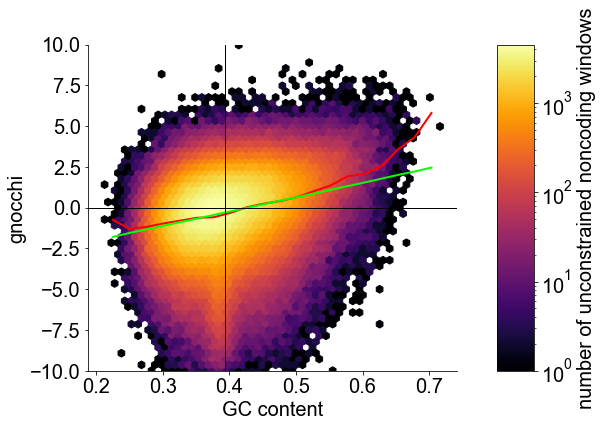

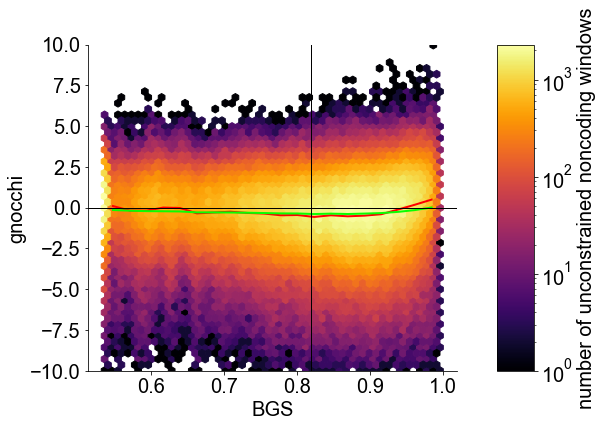

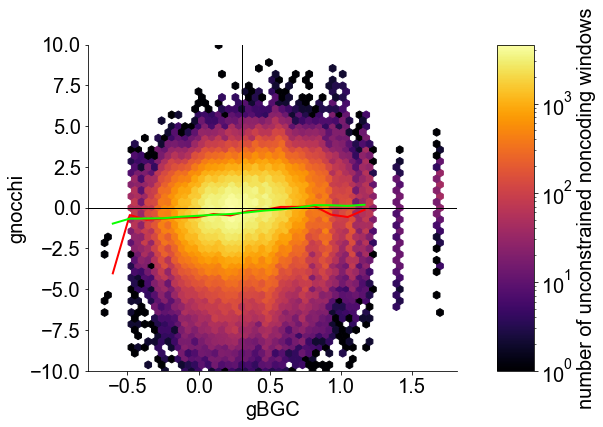

(regression coefficient:      Estimated value  Standard error        p-value
 constraint score feature                                                   
 gnocchi          BGS               -0.078022        0.002248  8.425830e-264
                  GC content         0.500760        0.002236   0.000000e+00
                  gBGC               0.126630        0.002260   0.000000e+00,
 {'constraint score': 'gnocchi',
  'features': ['GC content', 'BGS', 'gBGC'],
  'R2': 0.07644844059149958})

In [5]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def fit_linear_model(df, features, features_alias, target, target_alias):
    X = df[features]

    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    standardized_features = [f'standardized_{feature}' for feature in features]
    X = pd.DataFrame(X, columns=standardized_features)

    X = sm.add_constant(X)

    y = df[target]

    model = sm.OLS(y, X)
    results = model.fit()

    y_pred = results.predict(X)
    df[f'predicted_{target}'] = y_pred
    
    rsquared_record = {
        'constraint score': target_alias,
        'features': features_alias,
        'R2': results.rsquared, # proportion of variance in target explained by linear model
    }

    coefficients = results.params
    standard_errors = results.bse
    pvalues = results.pvalues

    records = []
    for feature_alias, standardized_feature in zip(features_alias, standardized_features):
        for parameter in ['Estimated value', 'Standard error', 'p-value']:
            records.append({
                'constraint score': target_alias,
                'feature': feature_alias,
                'regression coefficient:': parameter, 
                'regression coefficient value': {
                    'Estimated value': coefficients[standardized_feature],
                    'Standard error': standard_errors[standardized_feature],
                    'p-value': pvalues[standardized_feature],
                }[parameter]
            })

    results_df = pd.DataFrame(records).reset_index(drop=True)
    
    results_df = results_df.pivot(
        index=["constraint score", "feature"], 
        columns=["regression coefficient:"], 
        values="regression coefficient value"
    )

    return results_df, rsquared_record

def plot_heat_map(df, feature, feature_alias, target, target_alias, min_windows=1):
    cmap='inferno'

    # from matplotlib.colors import LinearSegmentedColormap
    # # Create a colormap that goes from white to a less intense black
    # cmap = LinearSegmentedColormap.from_list(
    #     'custom', 
    #     [(0, 'white'), (1, '#444444')],  # '#444444' is a less intense black
    # )

    fig, (ax_joint, ax_colorbar) = plt.subplots(1, 2, figsize=(8, 6), gridspec_kw={'width_ratios': [5, 0.5]})

    for side in ['top', 'right']:
        ax_joint.spines[side].set_visible(False)

    ax_joint.set_ylim(-10, 10)

    hb = ax_joint.hexbin(
        df[feature], 
        df[target], 
        gridsize=50, 
        cmap=cmap, 
        norm=LogNorm(),  # Apply LogNorm here
        mincnt=min_windows,
    )

    df[f'{feature}_bin_midpoints'] = (pd
        .cut(df[feature], bins=20, labels=None)
        .apply(lambda x: (x.right + x.left) / 2)
    )

    average_target = df.groupby(f'{feature}_bin_midpoints')[target].mean()
    average_predicted_target = df.groupby(f'{feature}_bin_midpoints')[f'predicted_{target}'].mean()

    ax_joint.plot(average_target.index, average_target.values, color='red', lw=2, label=f'mean {target_alias}') 
    ax_joint.plot(average_predicted_target.index, average_predicted_target.values, color=(8/255, 255/255, 0/255), lw=2, label=f'predicted {target_alias}') # green

    ax_joint.axvline(df[feature].mean(), color='black', lw=1)
    ax_joint.axhline(0, color='black', lw=1)

    ax_joint.set_xlabel(feature_alias)
    ax_joint.set_ylabel(target_alias)

    cbar = plt.colorbar(hb, cax=ax_colorbar)
    cbar.set_label('number of unconstrained noncoding windows')

    plt.show()

def plot_heat_maps(df, features, features_alias, target, target_alias):
    for feature, feature_alias in zip(features, features_alias):
        plot_heat_map(df, feature, feature_alias, target, target_alias)

def fit_and_plot(df, features, features_alias, target, target_alias): 
    results_df, rsquared_record = fit_linear_model(df, features, features_alias, target, target_alias)
    plot_heat_maps(df, features, features_alias, target, target_alias)
    return results_df, rsquared_record

fit_and_plot(
    df=UNCONSTRAINED_NONCODING_CHEN_WINDOWS, 
    features=[f'GC_content_{GC_WINDOW_SIZE}bp', 'B', 'B_M1star.EUR'],
    features_alias=['GC content', 'BGS', 'gBGC'],
    target='gnocchi',
    target_alias='gnocchi'
)

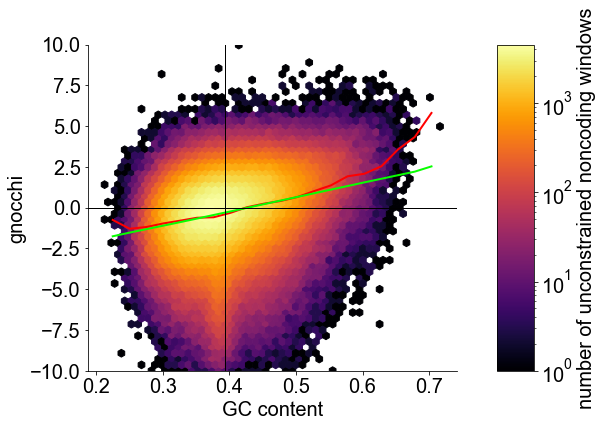

(regression coefficient:      Estimated value  Standard error  p-value
 constraint score feature                                             
 gnocchi          GC content          0.51114        0.002214      0.0,
 {'constraint score': 'gnocchi',
  'features': ['GC content'],
  'R2': 0.07136504880216643})

In [6]:
fit_and_plot(
    df=UNCONSTRAINED_NONCODING_CHEN_WINDOWS, 
    features=[f'GC_content_{GC_WINDOW_SIZE}bp'],
    features_alias=['GC content'],
    target='gnocchi',
    target_alias='gnocchi'
)

In [7]:
# TODO Mon Aug 19th 
# 1. use papers/neutral_models_are_biased/7.CDTS/main.2.ipynb to create CHEN_WINDOWS_WITH_LAMBDA_S, HALLDORSSON_WINDOWS, CDTS_WINDOWS
# 2. run fit_and_plot for all constraint scores (i.e., the additional dfs indicated in point 1), concatenating results_df (when using all features) and rsquared_record (when using only GC content)